# Hottest Day Date
This plays around with what determines the date of the hottest day of the year in a given region.

In [ ]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

In [ ]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    p_low_level = float(ds_use.pfull[-1]) * 100     # lowest atmospheric level
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

## Get datasets
Only consider one location (latitude and longitude) - see how date of hottest day varies in different years.

In [ ]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [288]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

loc = {'lat':60, 'lon': 180}

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(lat=loc['lat'], lon=loc['lon'], method='nearest')
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


## Annual Mean Seasonal Trend
This takes the annual mean, and plots the average surface and near-surface seasonal temperature cycle at the given location.

It also looks into how the winds, insolation, latent heat and relative humidity align with this temperature cycle.

In [299]:
# Take annual mean to see how temperature varies within a year on average
ds_annual_mean = [annual_mean(ds_all[i]) for i in range(n_exp)]
# Compute times corresponding to peaks in surface temperature
max_summer_time = ds_annual_mean[0].time[ds_annual_mean[0].time<8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time<8*30].to_numpy())]
max_winter_time = ds_annual_mean[0].time[ds_annual_mean[0].time>8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time>8*30].to_numpy())]
if loc['lat'] > 30:
    # in extratropics, only one maxima
    max_winter_time = max_summer_time

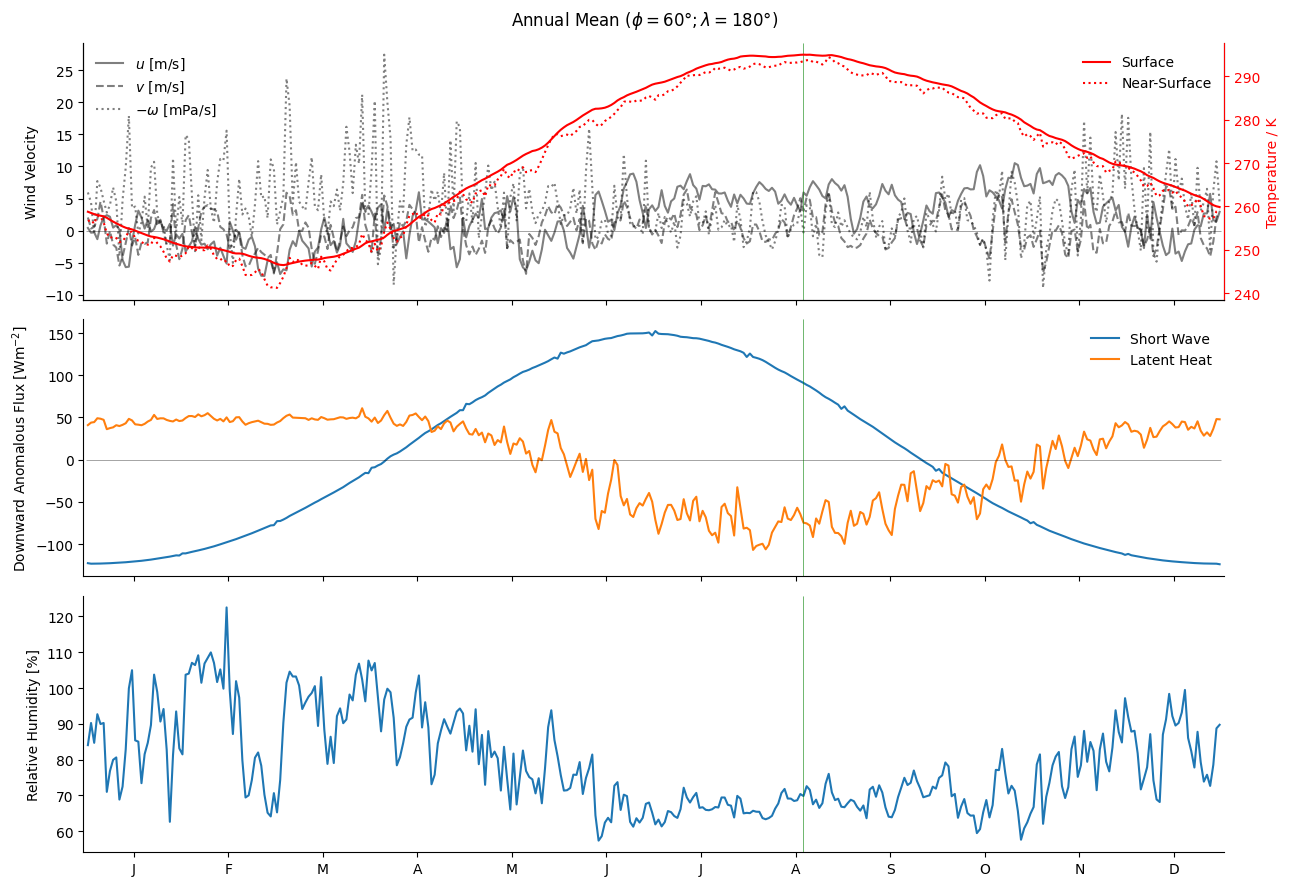

In [300]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(3,1, figsize=(13, 9), sharex=True)
ax2 = ax[0].twinx()
#ax2.set_ylim(-0.012,0.012)
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].vcomp, color='k', alpha=0.5, linestyle='--', label='$v$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, -ds_annual_mean[0].omega*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
ax[0].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(-1,361)
# ax[0].set_ylim(-18,18)
ax[0].set_ylabel('Wind Velocity')
ax[0].legend(frameon=False)
ax[0].legend(frameon=False, loc='upper left')

ax2.spines['top'].set_visible(False)
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].t_surf, color='r', label='Surface')
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].temp, color='r', linestyle=':', label='Near-Surface')
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylabel('Temperature / K', color='r')

ax[1].plot(ds_annual_mean[0].time, ds_annual_mean[0].swdn_sfc-np.mean(ds_annual_mean[0].swdn_sfc), label='Short Wave')
ax[1].plot(ds_annual_mean[0].time, -(ds_annual_mean[0].flux_lhe-np.mean(ds_annual_mean[0].flux_lhe)), label='Latent Heat')
# ax[1].plot(ds_annual_mean[0].swdn_sfc - ds_annual_mean[0].flux_lhe)
ax[1].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_ylabel('Downward Anomalous Flux [Wm$^{-2}$]')
ax[1].legend(frameon=False)

ax[2].plot(ds_annual_mean[0].time, 100*ds_annual_mean[0].sphum/sphum_sat(ds_annual_mean[0].temp,p_low_level))
ax[2].set_xticks(*month_ticks)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_ylabel('Relative Humidity [%]')

for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

## Temperature Tendency
At the surface, the temperature tendency, $\partial T/\partial t$, can be computed through the surface energy budget:
$$C\frac{\partial T}{\partial t} = F = SW^{\downarrow} + LW^{\downarrow} - LW^{\uparrow} + LH^{\downarrow} + SH^{\downarrow}$$
Where $F$ is the net flux into the surface (units of $Wm^{-2}$), and $C = c_{p, water}\rho_{water} h$ is the heat capacity of the ocean mixed layer in units of $Jkg^{-1}m^{-2}$.

The plot below confirms that the two sides of the equation match up.

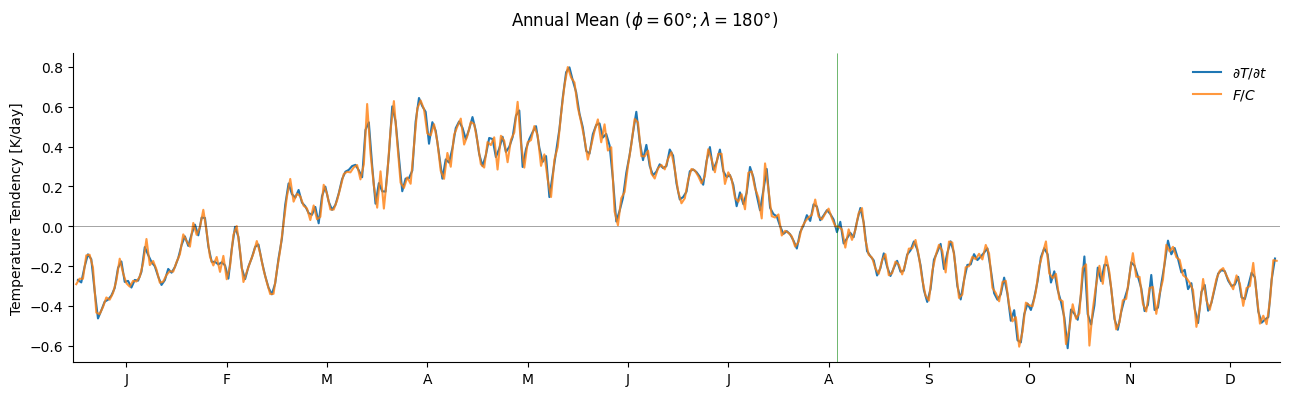

In [301]:
# Compute temperature tendency
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
net_flux_surface = ds_annual_mean[0].swdn_sfc + ds_annual_mean[0].lwdn_sfc - ds_annual_mean[0].lwup_sfc - \
                   ds_annual_mean[0].flux_lhe - ds_annual_mean[0].flux_t        # flux_lhe and flux_t defined as upward being positive
day_seconds = 24*60**2
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_annual_mean[0].time[:-1], np.ediff1d(ds_annual_mean[0].t_surf), label='$\partial T/\partial t$')
ax.plot(ds_annual_mean[0].time-0.5, net_flux_surface/ heat_capacity * day_seconds, alpha=0.8, label='$F/C$')
ax.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax.legend(frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.set_ylabel('Temperature Tendency [K/day]')

for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Breakdown of Surface Fluxes
The second plot below decomposes the temperature tendencies into contributions from each of the different surface fluxes. The third plot is the same as the second, but I have removed the mean for each flux i.e. it shows the anomaly from the mean for each flux.

For a given day in the last plot, I sum the temperature tendencies over the preceeding 10 days.

In [302]:
def sum_prev_days(var, n_days):
    """
    Assumes var wraps around i.e. when reaches the end, it wraps around to the beginning.
    Args:
        var: Variable to average over previous n_days
        n_days: Number of days to average over
    Returns:
        var_av[i] is the sum from var[i-n_days] to var_av[i]
    """
    kernel_array = np.zeros(2*n_days+1)
    kernel_array[:n_days] = 1
    return np.convolve(np.pad(var, [n_days, n_days], mode='wrap'), np.flip(kernel_array), mode='valid')

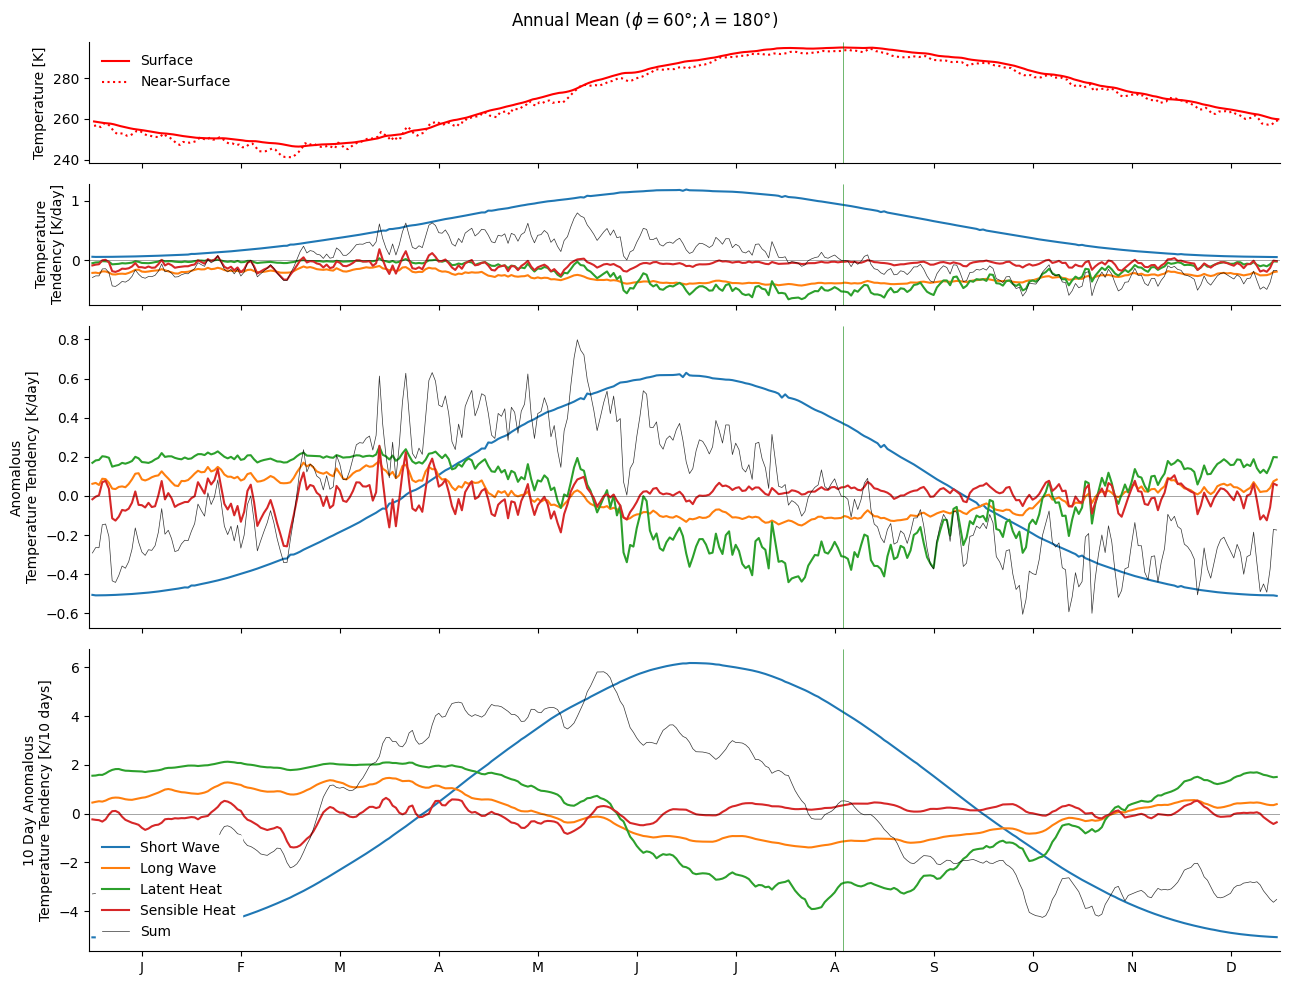

In [303]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
flux_names = ['Short Wave', 'Long Wave', 'Latent Heat', 'Sensible Heat']
n_day_sum = 10      # for one plot, sum temperature tendency over preceeding `n_day_sum` days.

fig, ax = plt.subplots(4,1, figsize=(13, 10), gridspec_kw={'height_ratios': [1, 1, 2.5, 2.5]}, sharex=True)
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].t_surf, color='r', label='Surface')
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].temp, color='r', linestyle=':', label='Near-Surface')
for i, flux in enumerate([ds_annual_mean[0].swdn_sfc, ds_annual_mean[0].lwdn_sfc - ds_annual_mean[0].lwup_sfc,
                          -ds_annual_mean[0].flux_lhe, -ds_annual_mean[0].flux_t]):
    ax[1].plot(ds_annual_mean[0].time-0.5, flux/heat_capacity * day_seconds)
    ax[2].plot(ds_annual_mean[0].time-0.5, (flux-np.mean(flux))/heat_capacity * day_seconds)
    ax[3].plot(ds_annual_mean[0].time-0.5,sum_prev_days((flux-np.mean(flux))/heat_capacity * day_seconds, n_day_sum),
               label = flux_names[i])
ax[3].plot(ds_annual_mean[0].time-0.5, sum_prev_days((net_flux_surface-np.mean(net_flux_surface))/heat_capacity * day_seconds, n_day_sum),
           color='k', label='Sum', alpha=0.8, lw=0.5)
ax[1].plot(ds_annual_mean[0].time-0.5, net_flux_surface/ heat_capacity * day_seconds, color='k', alpha=0.8, lw=0.5)
ax[2].plot(ds_annual_mean[0].time-0.5, (net_flux_surface-np.mean(net_flux_surface))/ heat_capacity * day_seconds, color='k', alpha=0.8, lw=0.5)
ax[0].set_xlim(-1,360)
ax[0].legend(frameon=False)
ax[3].legend(edgecolor='white', loc='lower left', framealpha=1)
ax[0].set_xticks(*month_ticks)
for ax_use in ax:
    ax_use.spines[['right', 'top']].set_visible(False)
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
    ax_use.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature\nTendency [K/day]')
ax[2].set_ylabel('Anomalous\nTemperature Tendency [K/day]')
ax[3].set_ylabel(f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Latent Heat Decomposition
I think the latent heat formula in *Isca* is linearly related to the bulk formula for evaporation:
$$E = \rho_aC_{drag}|v_a|(q^*_s - q_a)$$

According to [Frierson 2006](https://journals.ametsoc.org/view/journals/atsc/63/10/jas3753.1.xml), $v_a$, $\rho_a$ and $q_a$ are the horizontal wind, density and specific humidity evaluated at the lowest atmospheric level. $q_s^*$ is the saturation specific humidity at the surface temperature. The drag coefficient, $C_{drag}$, is calculated according to a simplified Monin–Obukhov similarity (MOS) theory.\

As the $C_{drag}$ term is quite complicated, below I see how the latent heat flux output by Isca and $|v_a|(q^*_s - q_a)$ compare. They seem to match up pretty well hence I ignore the drag term in the following analysis.

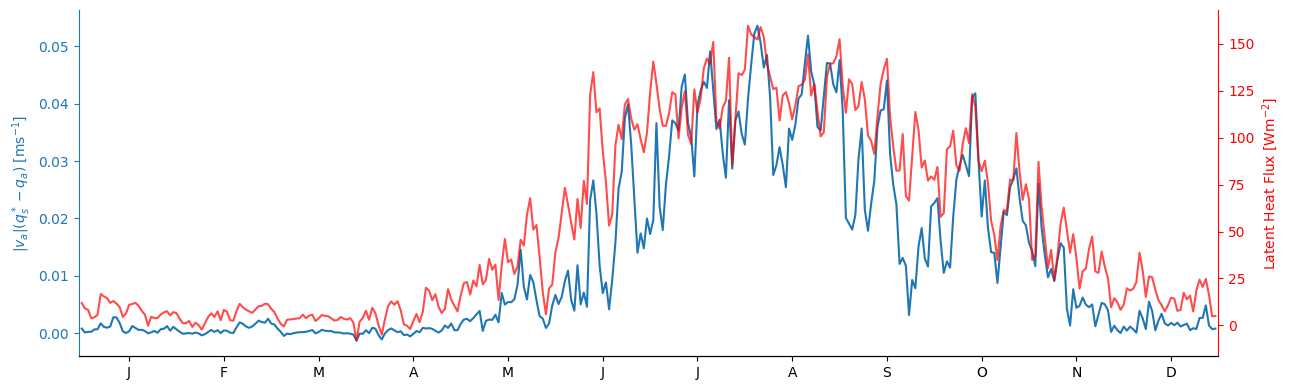

In [304]:
# omega = -ds_annual_mean[0].omega / (1.293 * 9.81)
p_surface = np.mean(ds_annual_mean[0].ps)       # surface pressure level - assume constant
wind_speed = np.sqrt(ds_annual_mean[0].vcomp**2 + ds_annual_mean[0].ucomp**2)
sphum_diff = sphum_sat(ds_annual_mean[0].t_surf, p_surface) - ds_annual_mean[0].sphum
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(ds_annual_mean[0].time-0.5, wind_speed * sphum_diff, color=default_colors[0])
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_color(default_colors[0])
ax.tick_params(axis='y', colors=default_colors[0])
ax.set_ylabel('$|v_a|(q^*_s - q_a)$ [ms$^{-1}$]', color=default_colors[0])
ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(ds_annual_mean[0].time-0.5, ds_annual_mean[0].flux_lhe, color='r', alpha=0.7)
ax2.tick_params(axis='y', colors='r')
ax2.spines['right'].set_color('r')
ax2.set_ylabel('Latent Heat Flux [Wm$^{-2}$]', color='r')
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
plt.tight_layout();

The $|v_a|(q^*_s - q_a)$ term can be written as $|v_a|(q^*(T_s) - r_aq^*(T_a))$ and as such depends on near-surface wind speed $v_a$, surface temperature $T_s$, near-surface temperature $T_{a}$ and near-surface relative humidity $r_a$.

If I do a taylor expansion of $q^*(T_a)$ about $T_s$, I can write this as $|v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg)$ where $T_{a-s} = T_{a}-T_{s}$ and $\alpha_s$ is the clausius clapeyron parameter evaluated at the surface. The comparison between the blue and orange lines below confirms that this is a good approximation.

Given this form of the latent heat contribution, I do a taylor series expanding the latent heat in terms of deviations from the mean of $|v_a|$, $T_s$, $T_{a-s}$ and $r_a$ i.e.

$$LH \approx |v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg) \approx |\overline{v_a}|q^*(\overline{T_s})\bigg(1 - \overline{r_a}(1 + \overline{\alpha_s} \overline{T_{a-s}})\bigg) + \mu_{v_a}\Delta v_a + \mu_{r_a}\Delta r_a + \mu_{T_{a-s}} \Delta T_{a-s} +
\mu_{T_s} \Delta T_s + \frac{1}{2}\mu_{T^2_s} \Delta T^2_s  + \mu_{T_sv_a} \Delta T_s \Delta v_a$$

Where the $\mu$ terms represent the taylor coefficients i.e. $\mu_{T_s} = \frac{\partial LH}{\partial T_s}$ and $\mu_{T^2_s} = \frac{\partial^2 LH}{\partial T^2_s}$.

The $\Delta$ terms reflect the difference to the mean i.e. $\Delta T_s = T_s - \overline{T_s}$.

This approximation shown by the difference between the orange and green lines is fairly good, if not as good as the initial one.

In [305]:
# Required variables for taylor series expansion about mean for latent heat
alpha_s = clausius_clapeyron_factor(ds_annual_mean[0].t_surf, p_surface)
q_sat_s = sphum_sat(ds_annual_mean[0].t_surf, p_surface)
r_a = ds_annual_mean[0].sphum/sphum_sat(ds_annual_mean[0].temp, p_low_level)
temp_diff = ds_annual_mean[0].temp - ds_annual_mean[0].t_surf

v_mean = np.mean(wind_speed)
delta_v = wind_speed - v_mean
temp_s_mean = np.mean(ds_annual_mean[0].t_surf)
delta_temp_s = ds_annual_mean[0].t_surf - temp_s_mean
temp_diff_mean = np.mean(temp_diff)
delta_temp_diff = temp_diff - temp_diff_mean
r_a_mean = np.mean(r_a)
delta_r_a = r_a - r_a_mean
q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)

# Decompose latent heat into contributions from each variable
lh_mean = v_mean * q_sat_s_mean * (1 - r_a_mean * (1 + temp_diff_mean * alpha_s_mean))
lh_taylor_terms = {}
lh_taylor_terms['wind'] = lh_mean/v_mean * delta_v
lh_taylor_terms['r_a'] = - v_mean * q_sat_s_mean * (1+temp_diff_mean * alpha_s_mean) * delta_r_a
lh_taylor_terms['temp_diff'] = - v_mean * q_sat_s_mean * r_a_mean * alpha_s_mean * delta_temp_diff
lh_taylor_terms['temp_s'] = v_mean * q_sat_s_mean * alpha_s_mean * (
        1 - r_a_mean - (r_a_mean * temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2)) * delta_temp_s
# quite important to include temperature squared and non-linear temp-wind terms
lh_taylor_terms['temp_s_squared'] = v_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
    alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean + 6*r_a_mean*temp_diff_mean)
    - 2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean) * 0.5 * delta_temp_s**2   # squared taylor series, need 0.5 factor
lh_taylor_terms['wind_temp_s'] = lh_taylor_terms['temp_s']/v_mean * delta_v

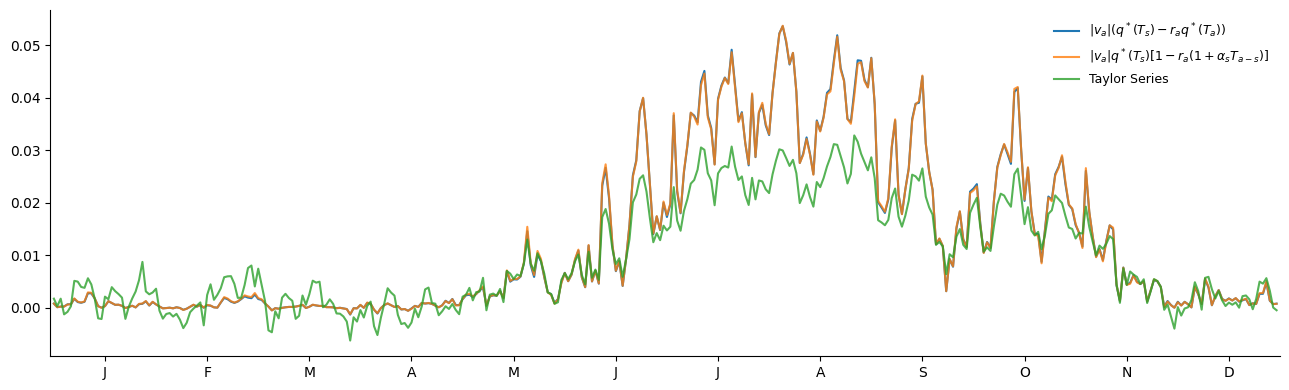

In [306]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(ds_annual_mean[0].time-0.5, wind_speed * sphum_diff, label='$|v_a|(q^*(T_s) - r_aq^*(T_a))$')
ax.plot(ds_annual_mean[0].time-0.5, wind_speed * q_sat_s * (1 - r_a * (1+temp_diff * alpha_s)), alpha=0.8,
        label='$|v_a|q^*(T_s)[1 - r_a(1 + \\alpha_s T_{a-s})]$')
ax.plot(ds_annual_mean[0].time-0.5, lh_mean + sum(lh_taylor_terms.values()), alpha=0.8, label='Taylor Series')
ax.legend(fontsize=9, frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
plt.tight_layout()

In [307]:
v_mean = np.mean(wind_speed)
delta_v = wind_speed - v_mean
temp_s_mean = np.mean(ds_annual_mean[0].t_surf)
delta_temp_s = ds_annual_mean[0].t_surf - temp_s_mean
temp_diff_mean = np.mean(temp_diff)
delta_temp_diff = temp_diff - temp_diff_mean
r_a_mean = np.mean(r_a)
delta_r_a = r_a - r_a_mean
q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)

lh_mean = v_mean * q_sat_s_mean * (1 - r_a_mean * (1 + temp_diff_mean * alpha_s_mean))
lh_taylor_terms = {}
lh_taylor_terms['wind'] = lh_mean/v_mean * delta_v
lh_taylor_terms['temp_s'] = v_mean * q_sat_s_mean * alpha_s_mean * (
        1 - r_a_mean - (r_a_mean * temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2)) * delta_temp_s
lh_taylor_terms['r_a'] = - v_mean * q_sat_s_mean * (1+temp_diff_mean * alpha_s_mean) * delta_r_a
lh_taylor_terms['temp_diff'] = - v_mean * q_sat_s_mean * r_a_mean * alpha_s_mean * delta_temp_diff
lh_taylor_terms['wind_temp_s'] = lh_taylor_terms['temp_s']/v_mean * delta_v
lh_taylor_terms['temp_s_squared'] = v_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
    alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean + 6*r_a_mean*temp_diff_mean)
    - 2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean) * 0.5 * delta_temp_s**2   # squared taylor series, need 0.5 factor

Now that I have confirmed that the taylor series approximation is a decent one, below I see how the different terms contribute.

For the second plot, I show the sum over the previous 10 days.

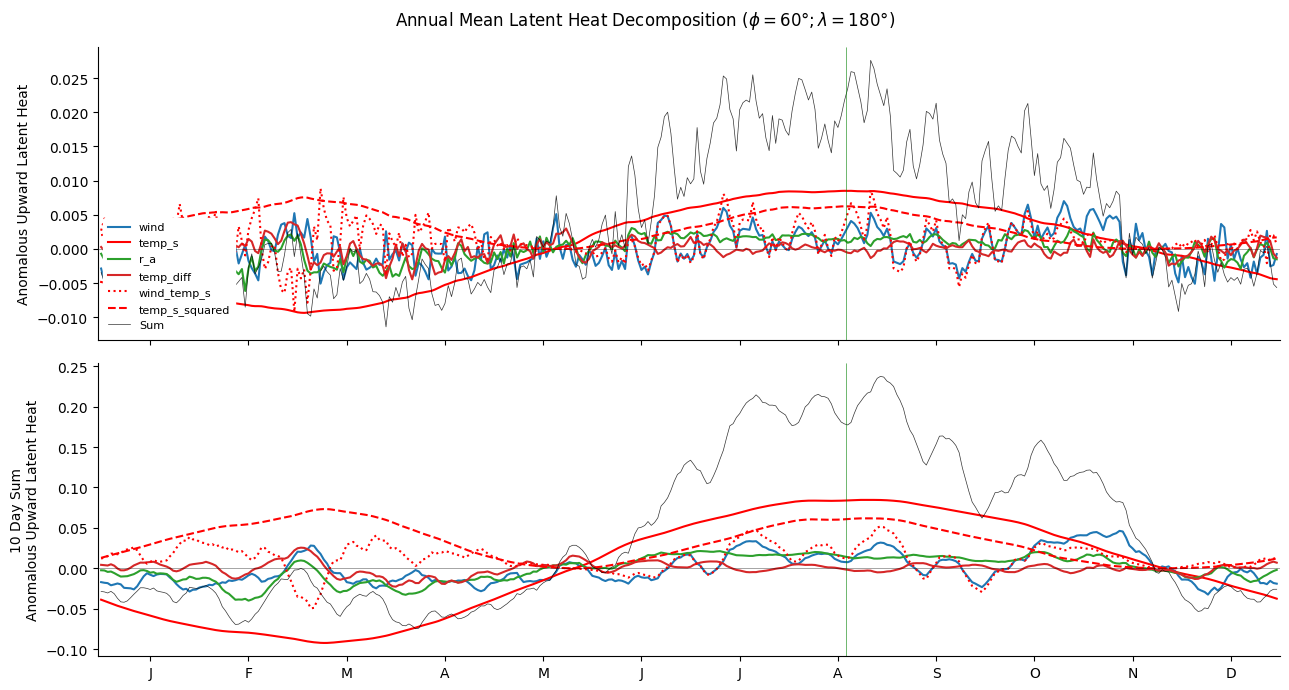

In [308]:
fig, ax = plt.subplots(2,1, figsize=(13, 7), sharex=True)
for i, key in enumerate(lh_taylor_terms):
    if 'squared' in key:
        linestyle = '--'
    elif 'wind_temp' in key:
        linestyle = ':'
    else:
        linestyle = '-'
    ax[0].plot(ds_annual_mean[0].time-0.5, lh_taylor_terms[key], label=key, color='r' if 'temp_s' in key else default_colors[i],
               linestyle=linestyle)
    ax[1].plot(ds_annual_mean[0].time-0.5, sum_prev_days(lh_taylor_terms[key], n_day_sum),
               label=key, color='r' if 'temp_s' in key else default_colors[i], linestyle=linestyle)
ax[0].plot(ds_annual_mean[0].time-0.5, sum(lh_taylor_terms.values()), color='k', alpha=0.8, lw=0.5, label='Sum')
ax[1].plot(ds_annual_mean[0].time-0.5, sum_prev_days(sum(lh_taylor_terms.values()), n_day_sum), color='k', alpha=0.8, lw=0.5, label='Sum')
ax[0].legend(loc='lower left', fontsize=8, framealpha=1, edgecolor='w')
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Anomalous Upward Latent Heat')
ax[1].set_ylabel(f'{n_day_sum} Day Sum\nAnomalous Upward Latent Heat')
for ax_use in ax:
    ax_use.spines[['top', 'right']].set_visible(False)
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
    ax_use.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
fig.suptitle(f"Annual Mean Latent Heat Decomposition ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()